# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType

from datetime import datetime
from datetime import date

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
       .builder \
       .appName("Sparkify-X") \
       .getOrCreate()

In [3]:
spark

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'muhammads-mbp.fritz.box'),
 ('spark.app.name', 'Sparkify-X'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1589924831261'),
 ('spark.driver.port', '61135'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [6]:
#Display first 3 rows - to get an idea
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
user_log.select("page").dropDuplicates().show(29)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [8]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
col_list = user_log.schema.names

In [10]:
col_list

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [11]:
user_log.count() #total entries

286500

In [12]:
empty_strings_dict = {}
for col in col_list:
 empty_strings_dict[col] = user_log.filter(user_log[col] == '').count()   

In [13]:
null_val_dict = {}
for col in col_list:
 null_val_dict[col] = user_log.filter(user_log[col].isNull()).count()


In [101]:
#dictionary - with number of null values for each colummn
print('NULL VALUES:')
print(null_val_dict) #dictionary - with number of null values for each colummn
print('--------------------------------------------------------------------------------------------------------------------')
print('EMPTY STRINGS:')
print(empty_strings_dict) #dictionary - with number of emptry string for each colummn

NULL VALUES:
{'artist': 58392, 'auth': 0, 'firstName': 8346, 'gender': 8346, 'itemInSession': 0, 'lastName': 8346, 'length': 58392, 'level': 0, 'location': 8346, 'method': 0, 'page': 0, 'registration': 8346, 'sessionId': 0, 'song': 58392, 'status': 0, 'ts': 0, 'userAgent': 8346, 'userId': 0}
--------------------------------------------------------------------------------------------------------------------
EMPTY STRINGS:
{'artist': 0, 'auth': 0, 'firstName': 0, 'gender': 0, 'itemInSession': 0, 'lastName': 0, 'length': 0, 'level': 0, 'location': 0, 'method': 0, 'page': 0, 'registration': 0, 'sessionId': 0, 'song': 0, 'status': 0, 'ts': 0, 'userAgent': 0, 'userId': 8346}


In [16]:
#drop the empty strings
user_log = user_log.filter(user_log['userId'] != "")
#check number of entries after dropping rows with empty strings
print(user_log.count())

278154


In [17]:
total_locations = user_log.select("location").dropDuplicates().sort("location").count()
location = user_log.select("location").dropDuplicates().sort("location")
print('total locations', total_locations)

total locations 114


In [18]:
user_log.select("ts").dropDuplicates().sort("ts").show()
user_log.select("registration").dropDuplicates().sort("registration").show()

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
|1538353146000|
|1538353150000|
|1538353218000|
|1538353375000|
|1538353376000|
|1538353441000|
|1538353576000|
|1538353668000|
|1538353687000|
|1538353744000|
+-------------+
only showing top 20 rows

+-------------+
| registration|
+-------------+
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
|1531679695000|
+-------------+
only showing top 20 rows



In [19]:
user_log.select("gender").dropDuplicates().sort("gender").show()
user_log.select("level").dropDuplicates().sort("level").show()
user_log.select("method").dropDuplicates().sort("method").show()
user_log.select("auth").dropDuplicates().sort("auth").show()
user_log.select("status").dropDuplicates().sort("status").show()

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   GET|
|   PUT|
+------+

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [20]:
user_log.select("userAgent").dropDuplicates().sort("userAgent").show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [21]:
user_log.select("itemInSession").dropDuplicates().sort("status").show()


+-------------+
|itemInSession|
+-------------+
|          588|
|          347|
|          564|
|         1055|
|          241|
|          656|
|          853|
|         1200|
|         1319|
|          830|
|          551|
|          463|
|          155|
|          112|
|          299|
|          385|
|         1042|
|          167|
|          113|
|          237|
+-------------+
only showing top 20 rows



In [22]:
user_log.select("length").dropDuplicates().sort("length").show()


+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
#---FUNCTIONS---#

import matplotlib.pyplot as plt
#=============================================================
#
#=============================================================
def explore_data(df, target_col, exit):
    '''
    INPUT - df: dataframe 
            target_col: column in dataframe
            exit:  0 = non churned 1 = churned
    OUTPUT - total unique values in target column for selected Churn group 
    '''
    num = df[df['Churn'] == exit][[target_col]].drop_duplicates().count()
    return num

#=============================================================
#
#=============================================================
def plot_pie_chart(data1, data2, label1= 'Churned', label2='Not Churned'):
    '''
    INPUT - data1: total values from column1
            data2: total values from column2
            label1,2: default, self explanatory
    OUTPUT - pie chart showing percentage of data1 and data2
    '''
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
 labels = label1, label2
 sizes = [data1, data2]
 explode = (0, 0.1)  # only "explode" the 2nd slice - churned users

 fig1, ax1 = plt.subplots()
 ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
 ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

 plt.show()
    

#=============================================================
#
#============================================================= 
def get_total_number(df, cat_col, new_col):
   '''
    INPUT -  df:      dataframe
             cat_col: categorical column
             new_col: new column name 
    OUTPUT - data frame with new column containing sum of all the occurences of cat col
    '''
 df[new_col] = df.groupby('userId')[cat_col].transform('sum')
 return df


#===========================================================
# Following piece of code taken from matplot lib examples and 
# modified according to the needs
#===========================================================
def plot_over_time(df, eventcol, eventtype, time , xtitle , ytitle , kind = 'bar',heading1='Churned', heading2='Non Churned'):
 
   '''
    INPUT - df        : data frame
            eventcol  : event column - page
            eventype  : any event from page events
            x/ytitle  : self explanatory
            kind      : self explanatory
            heading1/2: self explanatory
    OUTPUT - bar chart showing trend over seleced time type for Churned/Non Churned users
   '''

 tmp = df[df['Churn'] == '1'][[eventcol, time]]
 grp1 = tmp[tmp[eventcol] == eventtype][time].value_counts(normalize=False)

 tmp = df[df['Churn'] == '0'][[eventcol, time]]
 grp2 = tmp[tmp[eventcol] == eventtype][time].value_counts(normalize=False, sort=False)

 labels = grp1.index

 x = np.arange(len(labels))  # the label locations
 width = 0.35  # the width of the bars

 fig, ax = plt.subplots()
 rects1 = ax.bar(x - width/2, grp1, width, label=heading1)
 rects2 = ax.bar(x + width/2, grp2, width, label=heading2)

 # Add some text for labels, title and custom x-axis tick labels, etc.
 ax.set_ylabel(ytitle)
 ax.set_xlabel(xtitle)
 ax.set_title('Scores by Event '+eventtype)
 ax.set_xticks(x)
 ax.set_xticklabels(labels)
 ax.legend()


 def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


 autolabel(rects1)
 autolabel(rects2)

 fig.tight_layout()

 plt.show()
    

In [24]:
#GET USERS WHO CHURNED
churned_users = user_log.select(["userId"]).filter(user_log.page == "Cancellation Confirmation")
churned_users = churned_users.toPandas()
churned_users = churned_users.userId.tolist()

In [25]:
churned_users

['18',
 '32',
 '125',
 '105',
 '17',
 '143',
 '101',
 '129',
 '121',
 '51',
 '87',
 '122',
 '12',
 '58',
 '73',
 '3',
 '106',
 '103',
 '28',
 '54',
 '29',
 '70',
 '53',
 '100011',
 '100001',
 '100024',
 '100006',
 '100019',
 '100003',
 '100023',
 '100005',
 '100017',
 '100025',
 '100009',
 '100012',
 '100013',
 '100022',
 '100014',
 '100015',
 '100021',
 '100007',
 '200001',
 '200024',
 '200011',
 '200021',
 '200018',
 '200015',
 '200017',
 '200016',
 '200020',
 '300007',
 '300001']

In [26]:
get_churn_users = udf(lambda x: 1 if( x in churned_users) else 0)

In [27]:
#Create Churn column and mark it 1 for users who churned
user_log = user_log.withColumn('Churn', get_churn_users("userId"))

In [28]:
user_log.select("Churn").dropDuplicates().show()

+-----+
|Churn|
+-----+
|    0|
|    1|
+-----+



In [29]:
#Decode timestamp into hour and month
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log = user_log.withColumn("month", get_month(user_log.ts))

In [30]:
user_log.take(2)


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn='0', hour='2', month='10'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', Churn='0', hour='2', month='10')]

In [31]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.Churn , user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show(24)

+-----+----+-----+
|Churn|hour|count|
+-----+----+-----+
|    0|   0| 8303|
|    1|   0| 1605|
|    0|   1| 7763|
|    1|   1| 1564|
|    0|   2| 7337|
|    1|   2| 1558|
|    1|   3| 1339|
|    0|   3| 7000|
|    0|   4| 7009|
|    1|   4| 1350|
|    0|   5| 6934|
|    1|   5| 1295|
|    1|   6| 1200|
|    0|   6| 6779|
|    1|   7| 1208|
|    0|   7| 6906|
|    0|   8| 6905|
|    1|   8| 1214|
|    1|   9| 1222|
|    0|   9| 7003|
|    1|  10| 1261|
|    0|  10| 7098|
|    1|  11| 1294|
|    0|  11| 7308|
+-----+----+-----+
only showing top 24 rows



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Churn   48 non-null     object
 1   hour    48 non-null     object
 2   count   48 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ KB
None


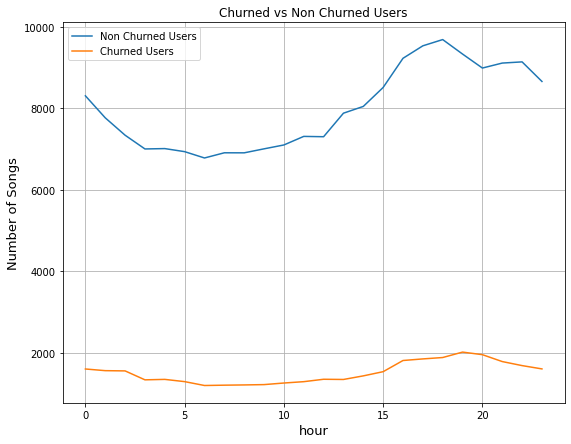

In [32]:
#Convert to Pandas for visualization
#Number of songs in 24 hours aggregated for churned and non churned users 

churn_usr_songs = songs_in_hour.toPandas()
print(churn_usr_songs.info())
churn_usr_songs['Churn'].value_counts()
ax = plt.gca()
ax.set_xlabel('Hours from 0-24', fontsize=13)
ax.set_ylabel('Number of Songs', fontsize= 13)

churn_usr_songs.groupby('Churn').plot(x='hour',y='count',title = 'Churned vs Non Churned Users' ,use_index=True,figsize = (9,7) ,legend = True, grid = True, ax=ax)
ax.legend(["Non Churned Users", "Churned Users"]);

In [33]:
#-Convert user_log to PANDAS for further exploration/visualizations --#

df_user_log     = user_log.toPandas()
df_user_log.info()

#Decode ts column into time, day, month and year
df_user_log['time']  = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). hour))
df_user_log['day']   = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). day))
df_user_log['month'] = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). month))
df_user_log['year']  = df_user_log['ts'].apply(lambda x: (datetime.fromtimestamp(x/1000.0). year))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           278154 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  278154 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          278154 non-null  object 
 8   location       278154 non-null  object 
 9   method         278154 non-null  object 
 10  page           278154 non-null  object 
 11  registration   278154 non-null  int64  
 12  sessionId      278154 non-null  int64  
 13  song           228108 non-null  object 
 14  status         278154 non-null  int64  
 15  ts             278154 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         278154 non-nul

In [34]:
df_user_log.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,Churn,hour,month,time,day,year
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,2,10,2,1,2018
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,2,10,2,1,2018
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,2,10,2,1,2018


In [35]:
#--------------------------------------------#
#REMOVING OUTLIER - DECEMEBER ONLY 4 ENTRIES
#--------------------------------------------#
print(df_user_log[df_user_log['month'] == 12][['userId', 'month']].head(5))
df_user_log = df_user_log.drop(df_user_log[df_user_log.month == 12].index)

       userId  month
207374    138     12
207375    138     12
207376     56     12
207377    152     12
207378     93     12


In [36]:
total_users = df_user_log['userId'].drop_duplicates().count()

num_churned_user    = explore_data(df_user_log, "userId", "1")
num_non_churned_user = explore_data(df_user_log,"userId", "0")

num_males   = df_user_log[df_user_log['gender'] == "M"][['userId']].drop_duplicates().count()
num_females = df_user_log[df_user_log['gender'] == "F"][['userId']].drop_duplicates().count()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


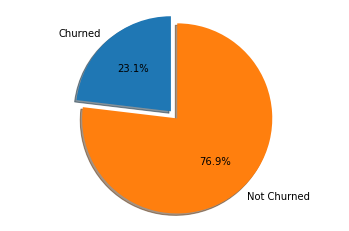

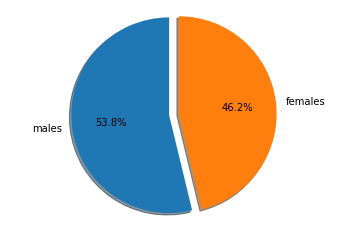

In [37]:
#--PLOT--#
plot_pie_chart(num_churned_user, num_non_churned_user)
plot_pie_chart(num_males, num_females, 'males', 'females')


In [38]:
print("TOTAL USERS:", total_users)
print("CHURNED USERS:",    num_churned_user.values)
print("NON CHURNED USERS:", num_non_churned_user.values)

TOTAL USERS: 225
CHURNED USERS: [52]
NON CHURNED USERS: [173]


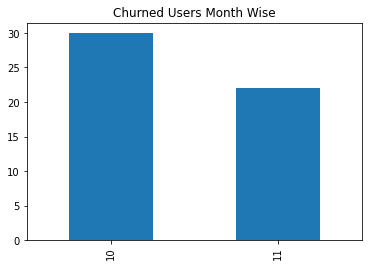

In [39]:
churned_timewise = df_user_log[df_user_log['page'] == 'Cancellation Confirmation'][['day', 'month']]
churned_timewise['month'].value_counts(sort=False).plot(kind='bar', use_index=True, title='Churned Users Month Wise')

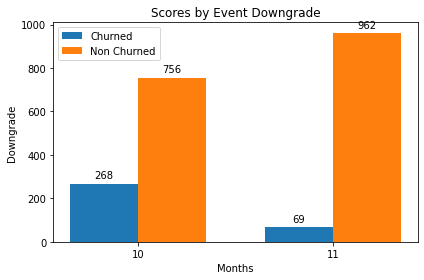

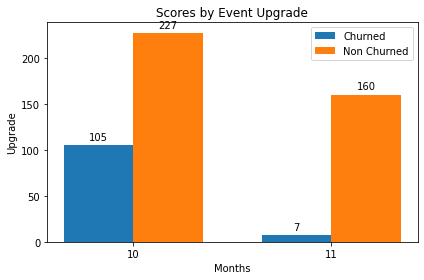

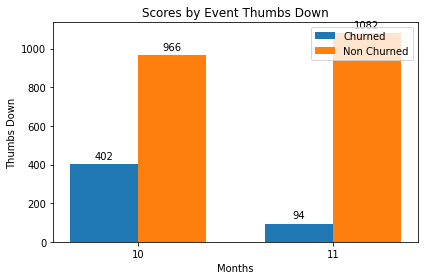

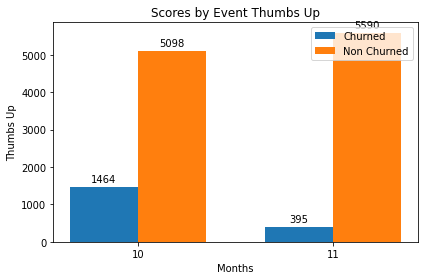

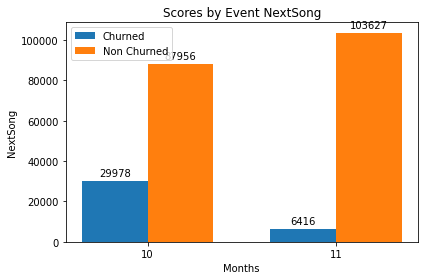

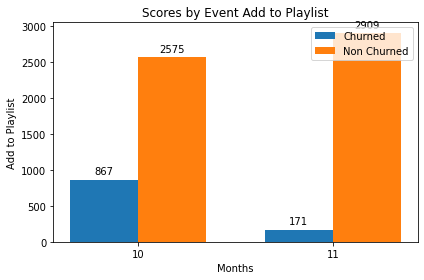

In [40]:
#Plot events month wise for Churned and Non Churned Users
to_plot = ['Downgrade', 'Upgrade', 'Thumbs Down' , 'Thumbs Up', 'NextSong', 'Add to Playlist']
for i in to_plot:
 plot_over_time(df_user_log, 'page' , i, 'month' , 'Months' , i)

In [41]:
#Get all the event names from page column
page_events_name = df_user_log['page'].unique()
page_events_name = list(page_events_name)

#-Convert Categorical Columns
df_events = pd.get_dummies(df_user_log, columns=['gender','level', 'page'])

#Create new column for example: num_NextSong
# sum all the events for each user and update respective event column
for name in page_events_name:
 df_events = get_total_number(df_events, 'page_'+name,'num_'+name)

df_events.columns 
print(df_events.shape)

(277995, 63)


In [42]:
#Since all the events for each user are summed up, drop other entries and keep only one entry for each user id
df_events = df_events.drop_duplicates(subset=['userId'], keep='first')
print(df_events.shape)


(225, 63)


In [43]:
df_events.head(3)

,artist,auth,firstName,itemInSession,lastName,length,location,method,registration,sessionId,...,num_Upgrade,num_Add Friend,num_Settings,num_Submit Upgrade,num_About,num_Submit Downgrade,num_Error,num_Save Settings,num_Cancel,num_Cancellation Confirmation
0,Martha Tilston,Logged In,Colin,50,Freeman,277.89016,"Bakersfield, CA",PUT,1538173362000,29,...,14,25,13,1,3,1,1,1,0,0
1,Five Iron Frenzy,Logged In,Micah,79,Long,236.09424,"Boston-Cambridge-Newton, MA-NH",PUT,1538331630000,8,...,6,40,12,2,9,1,3,1,0,0
17,Tokyo Police Club,Logged In,Ashlynn,0,Williams,166.11220,"Tallahassee, FL",PUT,1537365219000,217,...,3,43,17,2,4,1,1,1,0,0


In [44]:
churn    = df_user_log[df_user_log["Churn"] == '1']
not_churn= df_user_log[df_user_log["Churn"] == '0']

#--------------------------------------------------------------------------#   
#Following code is taken from the following link - it is not written by me-
#https://www.kaggle.com/bandiang2/prediction-of-customer-churn-at-a-bank
#--------------------------------------------------------------------------#   

#function  for pie plot for customer attrition types
import plotly.graph_objs as go #visualization
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

def plot_pie(column):
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [45]:
plot_pie('gender')

In [46]:
plot_pie('page')

In [47]:
plot_pie('auth')

In [48]:
plot_pie('level')

In [49]:
plot_pie('method')

In [50]:
plot_pie('status')

In [51]:
plot_pie('location')

In [99]:
#top 5 locations for user distribution
df_events['location'].value_counts().head(5)

Los Angeles-Long Beach-Anaheim, CA       16
New York-Newark-Jersey City, NY-NJ-PA    15
Dallas-Fort Worth-Arlington, TX           7
Phoenix-Mesa-Scottsdale, AZ               7
Charlotte-Concord-Gastonia, NC-SC         6
Name: location, dtype: int64

In [52]:
cols_to_plot=  []

for name in page_events_name:
  cols_to_plot.append('num_'+name)

print(cols_to_plot)

['num_NextSong', 'num_Add to Playlist', 'num_Roll Advert', 'num_Thumbs Up', 'num_Downgrade', 'num_Thumbs Down', 'num_Home', 'num_Logout', 'num_Help', 'num_Upgrade', 'num_Add Friend', 'num_Settings', 'num_Submit Upgrade', 'num_About', 'num_Submit Downgrade', 'num_Error', 'num_Save Settings', 'num_Cancel', 'num_Cancellation Confirmation']


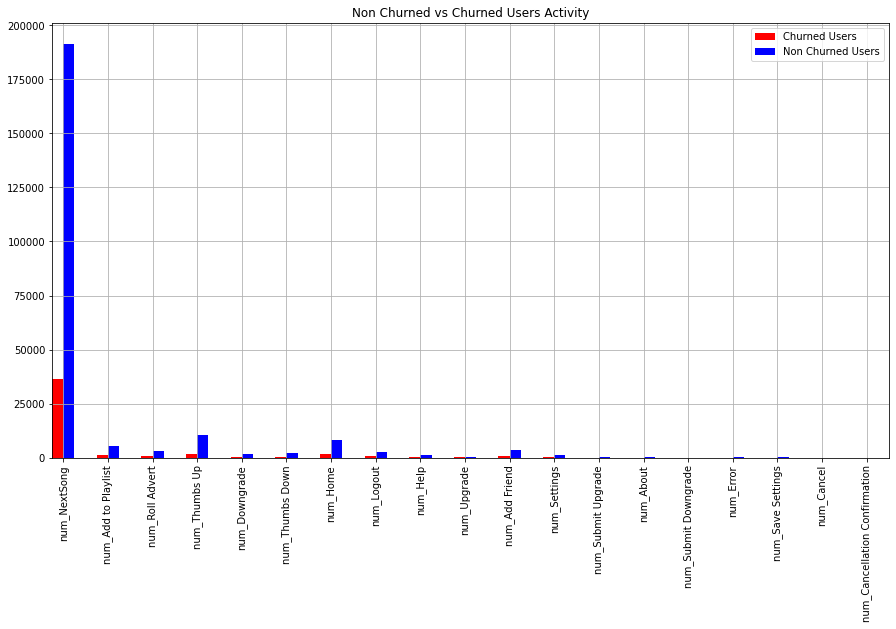

In [53]:
from matplotlib import cm

cmap1 = cm.get_cmap('autumn') # Colour map (there are many others)
cmap2 = cm.get_cmap('brg') # Colour map (there are many others)
ax = plt.gca()
df_events[df_events['Churn'] == '1'][cols_to_plot].sum().plot(kind='bar',width=0.25, alpha=1,figsize=(15,8), title="Churned Users Activity" , colormap = cmap1 ,position=1, ax=ax)
df_events[df_events['Churn'] == '0'][cols_to_plot].sum().plot(kind='bar',width=0.25,figsize=(15,8),title="Non Churned vs Churned Users Activity",  colormap = cmap2 ,position=0, ax=ax, grid=True)
ax.legend(["Churned Users","Non Churned Users"]);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [56]:
df_events[df_events.isna()].count()
df_events.columns
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 252939
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   artist                          110 non-null    object 
 1   auth                            225 non-null    object 
 2   firstName                       225 non-null    object 
 3   itemInSession                   225 non-null    int64  
 4   lastName                        225 non-null    object 
 5   length                          110 non-null    float64
 6   location                        225 non-null    object 
 7   method                          225 non-null    object 
 8   registration                    225 non-null    int64  
 9   sessionId                       225 non-null    int64  
 10  song                            110 non-null    object 
 11  status                          225 non-null    int64  
 12  ts                              2

In [57]:
feature_df_pd = df_events[['userId', 
                           'gender_F',
                           'gender_M',
                           'level_free',
                           'level_paid',
                           'num_NextSong', 
                           'Churn']]
feature_df_pd.head()

,userId,gender_F,gender_M,level_free,level_paid,num_NextSong,Churn
0,30,0,1,0,1,1405.0,0
1,9,0,1,1,0,2676.0,0
17,74,1,0,1,0,2400.0,0
22,54,1,0,0,1,2841.0,1
70,4,0,1,1,0,2048.0,0


In [58]:
#Convert Pandas Data Frame to Spark - for machine learning
feature_spark_df = spark.createDataFrame(feature_df_pd)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [59]:
feature_spark_df.columns[1:6]

['gender_F', 'gender_M', 'level_free', 'level_paid', 'num_NextSong']

In [61]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.feature import StringIndexer 
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator    
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

In [62]:
#NOT REQUIRED - DEPRECEATE IT
def get_accuracy(result):
   '''
    INPUT -  result:   predicated  dataframe
    OUTPUT - compite accuracy of the model - 
    '''
 true_pred_count = result.filter(result.label == result.prediction).count()
 print("Correct prediction:", true_pred_count)
 print("Total values:", result.count())
 print("Accuracy:" ,true_pred_count/result.count())

In [63]:
def get_eval_metrics(df):
 '''
    INPUT -  df:    predicted dataframe
    OUTPUT - print f1, precision, recall and accuracy metric of model
    '''
 predictionRDD = df.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
 metrics = MulticlassMetrics(predictionRDD)
 print("Precision:", metrics.precision())
 print("Accuracy:", metrics.accuracy)
 print("Recall:", metrics.recall())
 print("F1:", metrics.fMeasure())  
 print("Weighted Precision:",metrics.weightedPrecision)
 print("Weighted Recall:",metrics.weightedRecall)
 print("Weighted F1:",metrics.weightedFMeasure())

In [65]:
def config_pipeline(assembler, indexer,model):
    pipeline = Pipeline(stages=[assembler, indexer, model])
    return pipeline

In [94]:
(trainingData, testData) = feature_spark_df.randomSplit([0.7, 0.3])

In [95]:
assembler = VectorAssembler(inputCols=feature_spark_df.columns[1:6], outputCol="features")
indexer   = StringIndexer  (inputCol="Churn", outputCol="label")

In [96]:
#Define all the algorithms which we are going to use
rf           = RandomForestClassifier(featuresCol = 'features', labelCol = 'label' , maxDepth = 5, numTrees=20)
logistic_reg = LogisticRegression    (featuresCol = 'features', labelCol = 'label' , maxIter  = 50)
d_tree       = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label' , maxDepth = 5)
grad_bt      = GBTClassifier         (featuresCol = 'features', labelCol = 'label' , maxIter  = 50)
evaluator    = BinaryClassificationEvaluator()

In [97]:
#RandomForest
pipeline_rf  = config_pipeline(assembler, indexer,rf)
pmodel       = pipeline_rf.fit(trainingData)
result       = pmodel.transform(testData)
result.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|    39|  0.0|[17.7849678290250...|[0.88924839145125...|       0.0|
|    54|  1.0|[17.1011995789484...|[0.85505997894742...|       0.0|
|    74|  0.0|[17.5141344956917...|[0.87570672478458...|       0.0|
|    78|  0.0|[15.8994629283461...|[0.79497314641730...|       0.0|
|   120|  0.0|[19.1984218011706...|[0.95992109005853...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [98]:
#RandomForest Evaluation
print('ROC Value', evaluator.evaluate(result))
get_eval_metrics(result)

ROC Value 0.5476190476190476
Precision: 0.7
Accuracy: 0.7
Recall: 0.7
F1: 0.7
Weighted Precision: 0.5142857142857143
Weighted Recall: 0.7
Weighted F1: 0.5929411764705882


In [75]:
#Gradient BT Classifier
pipeline_grad  = config_pipeline(assembler, indexer,grad_bt)
grad_model     = pipeline_grad.fit(trainingData)
grad_pred      = grad_model.transform(testData)
grad_pred.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   101|  1.0|[0.14921382586713...|[0.57405809829240...|       0.0|
|    30|  0.0|[0.82399433961264...|[0.83861902935357...|       0.0|
|    45|  0.0|[1.35762400098839...|[0.93792042041009...|       0.0|
|    74|  0.0|[1.69765017511356...|[0.96755733636969...|       0.0|
|    88|  0.0|[1.56025986675358...|[0.95773127305831...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [76]:
#Gradient BT Classifier Evaluation
print('ROC:',evaluator.evaluate(grad_pred))
get_eval_metrics(grad_pred)

ROC: 0.5680778032036614
Precision: 0.676923076923077
Accuracy: 0.676923076923077
Recall: 0.676923076923077
F1: 0.676923076923077
Weighted Precision: 0.6012168622338114
Weighted Recall: 0.676923076923077
Weighted F1: 0.6129230769230769


In [77]:
#Logistic Regression 
pipeline_lr    =  config_pipeline(assembler, indexer,logistic_reg)
lrModel        =  pipeline_lr.fit(trainingData)
lrModel_pred   =  lrModel.transform(testData)
lrModel_pred.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   101|  1.0|[1.40889323086494...|[0.80359131839632...|       0.0|
|    30|  0.0|[1.80259725067436...|[0.85846480271223...|       0.0|
|    45|  0.0|[1.98447418001692...|[0.87915730476480...|       0.0|
|    74|  0.0|[2.41933812924168...|[0.91829009587514...|       0.0|
|    88|  0.0|[2.25080461180196...|[0.90471991666755...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [92]:
#Logistic Regression Evaluation
print("ROC:",evaluator.evaluate(lrModel_pred))
get_eval_metrics(lrModel_pred)

ROC: 0.4931350114416476
Precision: 0.7076923076923077
Accuracy: 0.7076923076923077
Recall: 0.7076923076923077
F1: 0.7076923076923077
Weighted Precision: 0.500828402366864
Weighted Recall: 0.7076923076923077
Weighted F1: 0.5865557865557866


In [79]:
#Decesion Tree
pipeline_dt   = config_pipeline(assembler, indexer,d_tree)
dtModel       = pipeline_dt.fit(trainingData)
dt_pred       = dtModel.transform(testData)
dt_pred.select('userId', 'label', 'rawPrediction' , 'probability' , 'prediction').show(5)

+------+-----+-------------+--------------------+----------+
|userId|label|rawPrediction|         probability|prediction|
+------+-----+-------------+--------------------+----------+
|   101|  1.0|   [51.0,4.0]|[0.92727272727272...|       0.0|
|    30|  0.0|   [51.0,4.0]|[0.92727272727272...|       0.0|
|    45|  0.0|   [51.0,4.0]|[0.92727272727272...|       0.0|
|    74|  0.0|   [51.0,4.0]|[0.92727272727272...|       0.0|
|    88|  0.0|   [51.0,4.0]|[0.92727272727272...|       0.0|
+------+-----+-------------+--------------------+----------+
only showing top 5 rows



In [93]:
#Decesion Tree Evaluation
print("ROC:",evaluator.evaluate(dt_pred))
get_eval_metrics(dt_pred)

ROC: 0.5068649885583524
Precision: 0.676923076923077
Accuracy: 0.676923076923077
Recall: 0.676923076923077
F1: 0.676923076923077
Weighted Precision: 0.4942612942612943
Weighted Recall: 0.676923076923077
Weighted F1: 0.5713479181369089


In [81]:
print(d_tree.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
m

In [82]:
# Set F-1 score as evaluation metric for best model selection
evaluator_ = MulticlassClassificationEvaluator(labelCol='label',
                                              predictionCol='prediction', metricName='f1')   

#Following two parameters chosen because of recommendation in spark api documentation
paramGrid = ParamGridBuilder() \
           .addGrid(d_tree.maxDepth, [5,8,10,12]) \
           .build()

cv = CrossValidator(estimator=pipeline_dt,                         
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_,
                    numFolds=3)  # use 3+ folds in practice

# Train model.  This also runs the indexers.
tuned_model = cv.fit(trainingData)
tuned_results = tuned_model.transform(testData)

In [83]:
get_eval_metrics(tuned_results)
print (evaluator_.getMetricName(), 'accuracy:', evaluator_.evaluate(tuned_results))

Precision: 0.676923076923077
Accuracy: 0.676923076923077
Recall: 0.676923076923077
F1: 0.676923076923077
Weighted Precision: 0.5719419924337956
Weighted Recall: 0.676923076923077
Weighted F1: 0.5942174850748602
f1 accuracy: 0.5942174850748602


In [84]:
# Set F-1 score as evaluation metric for best model selection
evaluator_ = MulticlassClassificationEvaluator(labelCol='label',
                                              predictionCol='prediction', metricName='f1')   

#Following two parameters chosen because of recommendation in spark api documentation
paramGrid = ParamGridBuilder() \
           .addGrid(rf.maxDepth, [5,8,10,12]) \
           .addGrid(rf.numTrees, [8,10,12,15,20,25]) \
           .build()

cv = CrossValidator(estimator=pipeline_rf,                         
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_,
                    numFolds=4)

# Train model.  This also runs the indexers.
tuned_model = cv.fit(trainingData)
info = tuned_model.bestModel.stages[2]
print(info)
tuned_results = tuned_model.transform(testData)

RandomForestClassificationModel (uid=RandomForestClassifier_3d065124b61e) with 10 trees


In [100]:
print (evaluator_.getMetricName(), 'accuracy:', evaluator_.evaluate(tuned_results))
get_eval_metrics(tuned_results)

f1 accuracy: 0.579020979020979
Precision: 0.6923076923076923
Accuracy: 0.6923076923076923
Recall: 0.6923076923076923
F1: 0.6923076923076923
Weighted Precision: 0.49759615384615385
Weighted Recall: 0.6923076923076923
Weighted F1: 0.579020979020979


In [90]:
#print(tuned_results.filter(tuned_results.label == tuned_results.prediction).count())
#print(tuned_results.count())
#tree_model = CV_model.bestModel.stages[2]
#print tree_model

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.